##  Clustering Headlines Based on Location
We are using machine learning to extract additional information from our data set, but this time we are compressing the data instead of adding more. We use the algorithm’s output to focus on only the most important clusters and headlines instead of having to examine them all.

In [51]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from mpl_toolkits.basemap import Basemap

import matplotlib.pyplot as plt
% matplotlib inline 

UsageError: Line magic function `%` not found.


## Data Processing
Drop the ones w/o valid geo info and have a look at the distribution of coordinates

In [3]:
hl2 = pd.read_csv(r'E:/Self-Dev/ManningProject-Headlines/data/hl2.csv',index_col = 0)
hl2 = hl2.dropna(subset=['latitude'])
hl2.describe()

latitude   longitude
count  617.000000  617.000000
mean    26.799818  -37.808243
std     20.479449   79.397115
min    -41.286640 -156.506040
25%     16.419040  -90.309280
50%     33.749000  -76.345220
75%     40.714270    6.930930
max     59.938630  179.364510

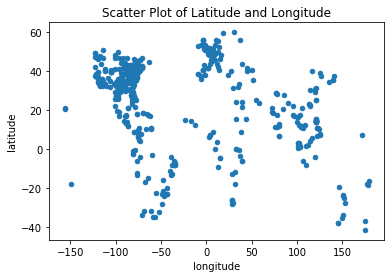

In [9]:
hl2.plot.scatter(x="longitude", y="latitude", title="Scatter Plot of Latitude and Longitude")

In [65]:
hl3 = hl2.drop_duplicates(subset = ['latitude','longitude'])
hl3.describe() # because we use some mean lat and lon for columns w/ only country info

latitude   longitude
count  580.000000  580.000000
mean    26.547747  -37.695062
std     20.488267   80.117223
min    -41.286640 -156.506040
25%     15.347915  -90.343035
50%     33.500035  -76.348955
75%     40.701768    8.091857
max     59.938630  179.364510

## KMeans clustering 
1. Use the default initial parameters;
2. Assign the cluster labels as another column;
3. You can use an elbow plot to select the number of clusters in KMeans.

### KMeans: Elbow Method

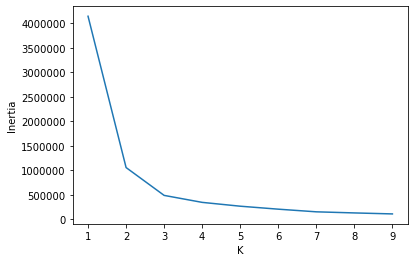

In [70]:
k_values = range(1, 10)
inertia_values = [KMeans(k).fit(hl2[['latitude','longitude']]).inertia_ for k in k_values]

plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show() # choose k = 3

### KMeans: Plot on map

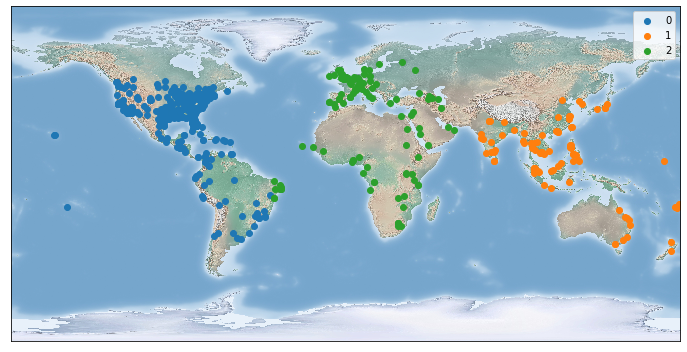

In [98]:
hl2['cluster'] = KMeans(3).fit_predict(hl2[['latitude','longitude']])
plot_on_earth(hl2)

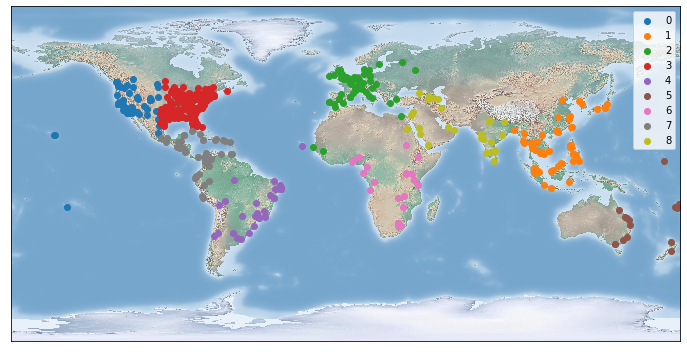

In [97]:
# Using 3 clusters seems not specific enough, by viewing, choose K = 9 for eg
hl2['cluster'] = KMeans(9).fit_predict(hl2[['latitude','longitude']])
plot_on_earth(hl2)

## the DBSCAN algorithm
4. The two most important parameters for DBSCAN are eps and min_samples. Try using DBSCAN with the great circle distance, which finds the distance between two geographic points on a spherical globe. Write a function to return the Great Circle distance between two coordinate points. Use this function as the metric for DBSCAN.

### DBSCAN: define great circle distance

In [139]:
import math 
def great_circle_distance(point_a, point_b):
    R = 3958.8 # radius of earth in miles
    
    lat_a, lon_a = tuple(map(math.radians, point_a))
    lat_b, lon_b = tuple(map(math.radians, point_b))
    
    angle = math.sin(lat_a)*math.sin(lat_b) + math.cos(lat_a)*math.cos(lat_b)*math.cos(abs(lon_a - lon_b))
    if abs(angle) > 1: # solve the problem of angle > 1 and could not be passing to acos
        angle = 1
    angle = math.acos(angle)
    return R*angle

### DBSCAN: Use eps = 250 (miles) and min_samples = 3 (cities)

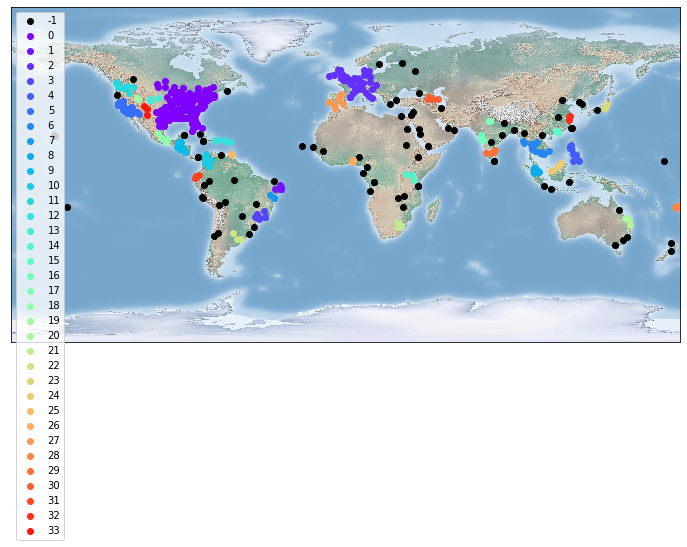

In [182]:
cluster_model = DBSCAN(eps = 250, min_samples = 3, metric = great_circle_distance)
hl2['cluster'] = cluster_model.fit_predict(hl2[['latitude','longitude']])
plot_on_earth(hl2)

I can see the above graph is not satisfying, both too many groups and outliers! So then I tried to change the parameters.
First I tried to understand how the eps and min_samples affect the results.
Belowing graphs showing:  
1. Large eps will reduce the # of groups and # of outliers.
2. Too large min_samples will make too many outliers.

I think I should increase eps somehow.

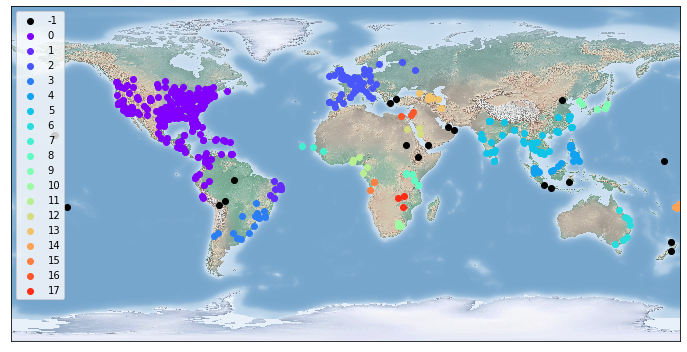

In [180]:
cluster_model = DBSCAN(eps = 500, min_samples = 3, metric = great_circle_distance)
hl2['cluster'] = cluster_model.fit_predict(hl2[['latitude','longitude']])
plot_on_earth(hl2)

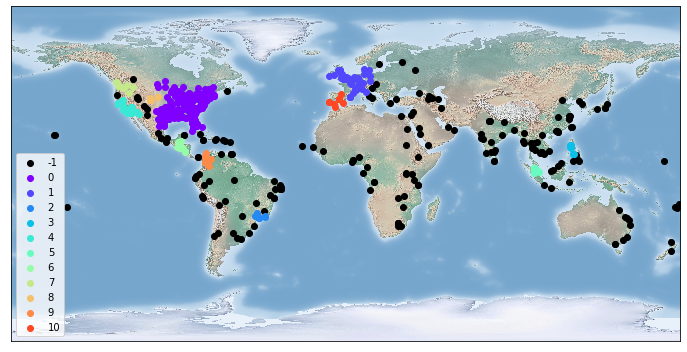

In [181]:
cluster_model = DBSCAN(eps = 250, min_samples = 7, metric = great_circle_distance)
hl2['cluster'] = cluster_model.fit_predict(hl2[['latitude','longitude']])
plot_on_earth(hl2)

Then I looped thru different combinations of eps and min_samples, choose several sets to do the plotting, see which works better.

In [183]:
x = np.linspace(250,700,10)
y = [2,3,4]
x_1, y_1 = np.meshgrid(x, y) 
x_1 = x_1.reshape(1,-1)[0]
y_1 = y_1.reshape(1,-1)[0]
for eps,min_samples in list(zip(x_1,y_1)):
    cluster_model = DBSCAN(eps, min_samples, metric = great_circle_distance)
    clusters = cluster_model.fit_predict(hl2[['latitude','longitude']])
    print(eps, min_samples, len(set(clusters)),sum(np.array(clusters) == -1))
    # print parameters and number of clusters, also the isolated points

250.0 2 55 46
300.0 2 45 35
350.0 2 40 23
400.0 2 42 13
450.0 2 34 9
500.0 2 25 8
550.0 2 22 6
600.0 2 17 4
650.0 2 14 4
700.0 2 12 4
250.0 3 35 86
300.0 3 29 67
350.0 3 27 49
400.0 3 28 41
450.0 3 25 27
500.0 3 19 20
550.0 3 17 16
600.0 3 14 10
650.0 3 11 10
700.0 3 9 10
250.0 4 22 130
300.0 4 23 89
350.0 4 24 64
400.0 4 24 56
450.0 4 18 50
500.0 4 13 42
550.0 4 15 30
600.0 4 11 22
650.0 4 9 18
700.0 4 7 17


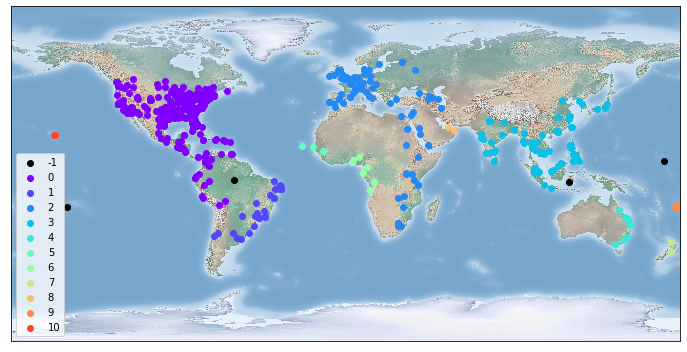

In [184]:
cluster_model = DBSCAN(eps = 700, min_samples = 2, metric = great_circle_distance)
hl2['cluster'] = cluster_model.fit_predict(hl2[['latitude','longitude']])
plot_on_earth(hl2)

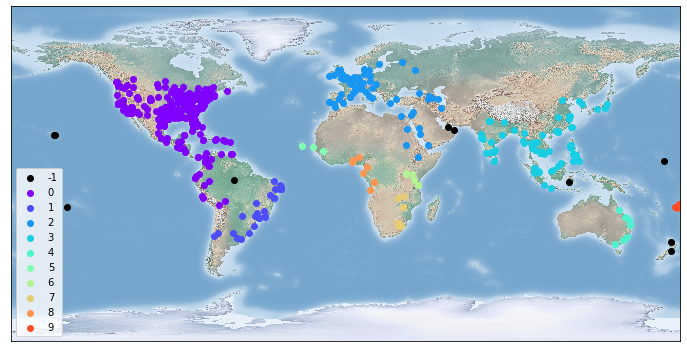

In [185]:
cluster_model = DBSCAN(eps = 650, min_samples = 3, metric = great_circle_distance)
hl2['cluster'] = cluster_model.fit_predict(hl2[['latitude','longitude']])
plot_on_earth(hl2)

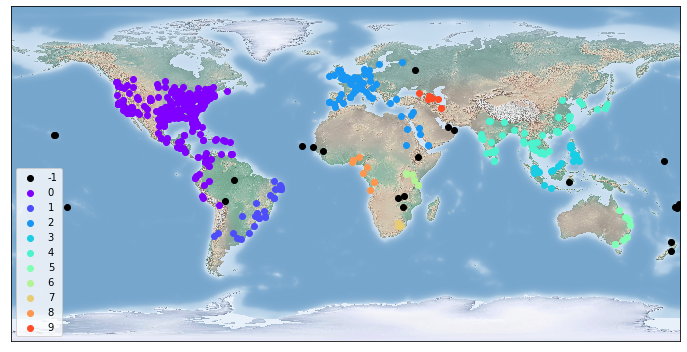

In [186]:
cluster_model = DBSCAN(eps = 600, min_samples = 4, metric = great_circle_distance)
hl2['cluster'] = cluster_model.fit_predict(hl2[['latitude','longitude']])
plot_on_earth(hl2)

### Function: Plotting Maps Using Basemap
3. Visualize the clusters on a world map using the Basemap library. 
4. Color the headlines by the cluster assignment, determine if the clusters are reasonable: Are headlines geographically close to one another in the same cluster?

Write a visualization function to quickly check clustering results.
Using our intuition—by visualizing the clusters—to determine if results are acceptable is common in data science.

In [178]:
import matplotlib.cm as cm
def plot_on_earth(df):
    map_plotter = Basemap()
    fig = plt.figure(figsize=(12, 8))
    n_groups = len(set(list(df['cluster'])))
    colors = cm.rainbow(np.linspace(0, 1, n_groups))
    for cluster_id, df_cluster in df.groupby('cluster'):
        map_plotter.scatter(df_cluster.longitude, df_cluster.latitude, latlon=True, label = cluster_id, \
                            color = colors[cluster_id] if cluster_id >= 0 else 'k') # will autoly use different colors
        #!!! color setting to avoid repeating colors and also point out the outliers
    map_plotter.shadedrelief()
    plt.legend()
    plt.show()

## Summary
From the pictures above, I think eps = 650, min_samples = 3 is the best combination of parameters.

In [187]:
cluster_model = DBSCAN(eps = 650, min_samples = 3, metric = great_circle_distance)
hl2['cluster'] = cluster_model.fit_predict(hl2[['latitude','longitude']])
hl2.to_csv('E:/Self-Dev/ManningProject-Headlines/data/hl3.csv')
hl2.head()

headline           city  \
Unnamed: 0                                                           
0                          Zika Outbreak Hits Miami          Miami   
1                   Could Zika Reach New York City?  New York City   
2                 First Case of Zika in Miami Beach    Miami Beach   
3           Mystery Virus Spreads in Recife, Brazil         Recife   
4           Dallas man comes down with case of Zika         Dallas   

                  country  latitude  longitude countrycode  cluster  
Unnamed: 0                                                           
0           United States  25.77427  -80.19366          US        0  
1           United States  40.71427  -74.00597          US        0  
2           United States  25.79065  -80.13005          US        0  
3                  Brazil  -8.05389  -34.88111          BR        1  
4           United States  32.78306  -96.80667          US        0

## Pkg Practices

### Model dart position

In [4]:
np.random.seed(0)
mean = 0
variance = 2
x = np.random.normal(mean, variance ** 0.5)
y = np.random.normal(mean, variance ** 0.5)
print(f"The x coordinate of a randomly thrown dart is {x:.2f}")
print(f"The y coordinate of a randomly thrown dart is {y:.2f}")

The x coordinate of a randomly thrown dart is 2.49
The y coordinate of a randomly thrown dart is 0.57


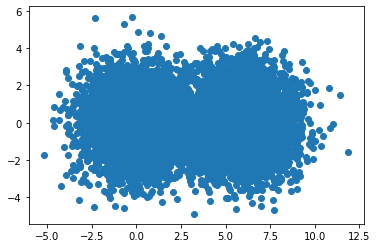

In [7]:
np.random.seed(1)
bulls_eye1 = [0, 0]
bulls_eye2 = [6, 0]
bulls_eyes = [bulls_eye1, bulls_eye2]
x_coordinates, y_coordinates = [], []
for bulls_eye in bulls_eyes:
    for _ in range(5000):
        x = np.random.normal(bulls_eye[0], variance ** 0.5)
        y = np.random.normal(bulls_eye[1], variance ** 0.5)
        x_coordinates.append(x)
        y_coordinates.append(y)

plt.scatter(x_coordinates, y_coordinates)
plt.show()

In [9]:
def nearest_bulls_eye(dart):
    distances = [euclidean(dart, bulls_e) for bulls_e in bulls_eyes]
    return np.argmin(distances) # returns index of nearest eye

# simulate 2 darts
darts = [[0,1], [6, 1]]
for dart in darts:
    index = nearest_bulls_eye(dart)
    print(f"The dart at position {dart} is closest to bulls-eye {index}")

The dart at position [0, 1] is closest to bulls-eye 0
The dart at position [6, 1] is closest to bulls-eye 1


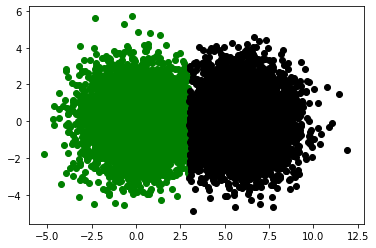

In [10]:
# for all darts, color them using euclidean distance
def color_by_cluster(darts):
    nearest_bulls_eyes = [nearest_bulls_eye(dart) for dart in darts]
    for bs_index in range(len(bulls_eyes)):
        selected_darts = [darts[i] for i in range(len(darts)) if bs_index == nearest_bulls_eyes[i]] # find darts belonging to this bulls_eye
        x_coordinates, y_coordinates = np.array(selected_darts).T # n*2 to 2*n !!! np.array().T
        plt.scatter(x_coordinates, y_coordinates, color=['g', 'k'][bs_index])
    plt.show()

darts = [[x_coordinates[i], y_coordinates[i]] for i in range(len(x_coordinates))]
color_by_cluster(darts)

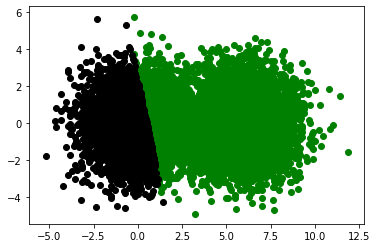

In [11]:
bulls_eyes = np.array(darts[:2]) # using first 2 darts as bulls_eyes (arbitrary center)
color_by_cluster(darts)

## K-means
Assigning the cluster’s mean coordinates to the bulls'-eye, re-apply our distance-based grouping technique.

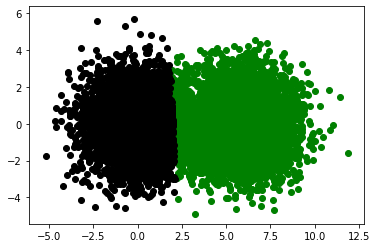

In [12]:
def update_bulls_eyes(darts):
    updated_bulls_eyes = []
    # current cluster
    nearest_bulls_eyes = [nearest_bulls_eye(dart) for dart in darts]
    # update center for each cluster
    for bs_index in range(len(bulls_eyes)):
        selected_darts = [darts[i] for i in range(len(darts)) if bs_index == nearest_bulls_eyes[i]]
        x_coordinates, y_coordinates = np.array(selected_darts).T
        mean_center = [np.mean(x_coordinates), np.mean(y_coordinates)]
        updated_bulls_eyes.append(mean_center)
    return updated_bulls_eyes

bulls_eyes = update_bulls_eyes(darts)
color_by_cluster(darts)

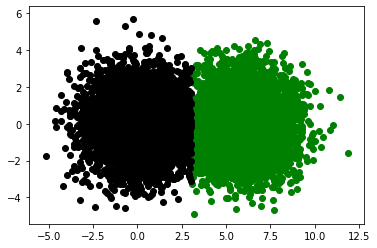

In [13]:
# Update 10 times
for i in range(10):
    bulls_eyes = update_bulls_eyes(darts)

color_by_cluster(darts)

### sklearn pkg

In [15]:
cluster_model = KMeans(n_clusters=2) # KMeans(n) w/ n be the center of cluster
assigned_bulls_eyes = cluster_model.fit_predict(darts)
#!!! fit_predict(self, X[, sample_weights]): Compute cluster centers(fit) & predict(predict) cluster index for each sample.
print("Bull's-eye assignments:")
print(assigned_bulls_eyes)

Bull's-eye assignments:
[1 1 1 ... 0 0 0]


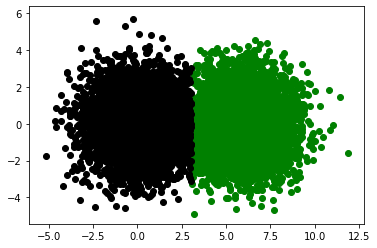

In [16]:
for bs_index in range(len(bulls_eyes)):
    selected_darts = [darts[i] for i in range(len(darts)) if bs_index == assigned_bulls_eyes[i]]
    x_coordinates, y_coordinates = np.array(selected_darts).T
    plt.scatter(x_coordinates, y_coordinates,color=['g', 'k'][bs_index])
plt.show()

In [17]:
new_darts = [[500, 500], [-500, -500]]
new_bulls_eye_assignments = cluster_model.predict(new_darts)
# assign a centroid to a data-point defined by x and y
for i, dart in enumerate(new_darts):
    bulls_eye_index = new_bulls_eye_assignments[i]
    print(f"Dart at {dart} is closest to bull's-eye {bulls_eye_index}")

Dart at [500, 500] is closest to bull's-eye 0
Dart at [-500, -500] is closest to bull's-eye 1


### Elbow Method
1. inertia: the sum of the squared distances between each point and its closest K-means center;
2. KMeans_model.inertia_: Returns the inertia associated with a [data-optimized] KMeans object.

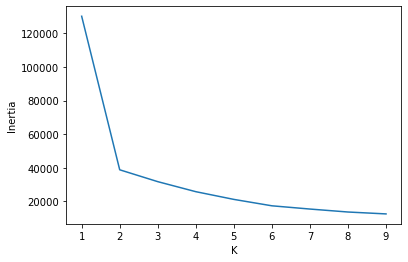

In [18]:
k_values = range(1, 10)
inertia_values = [KMeans(k).fit(darts).inertia_ for k in k_values] #!!! fit v.s. fit_predict # .inertia_

plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

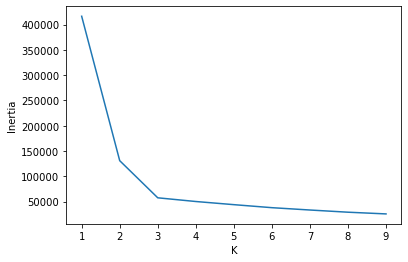

In [19]:
# add a nother bulls_eye and another 5000 darts
new_bulls_eye = [12, 0]
for _ in range(5000):
    x = np.random.normal(new_bulls_eye[0], variance ** 0.5)
    y = np.random.normal(new_bulls_eye[1], variance ** 0.5)
    darts.append([x, y])

inertia_values = [KMeans(k).fit(darts).inertia_ for k in k_values]

plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

In [ ]:
### A process
k_means_model = KMeans(n_clusters=K)
clusters = k_means_model.fit_predict(data)
new_clusters = k_means_model.predict(new_data)

inertia = k_means_model.inertia_
inertia = KMeans(n_clusters=K).predict(data).inerta_

## Silhouette score
sklearn.metrics.silhouette_score(X, labels, metric='euclidean', sample_size=None, random_state=None)
1. The Silhouette Coefficient for a sample is (b - a) / max(a, b)
2. mean intra-cluster distance (a)
3. mean nearest-cluster distance (b): mean distance between a sample and the nearest cluster that the sample is not a part of. 
4. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.
5. Bigger is better

In [26]:
import sklearn
for k in [2,3,4,5,6]:
    print(sklearn.metrics.silhouette_score(darts, KMeans(k).fit_predict(darts), metric='euclidean'))

0.5442892980459253
0.5681837414332824
0.44314844884759946
0.3744005110275977
0.30896106705684684


### Density-driven clusters

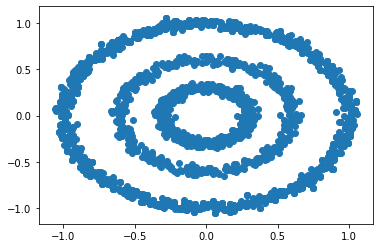

In [33]:
## Sampling
from sklearn.datasets import make_circles

x_coordinates = []
y_coordinates = []
for factor in [.3, .6, 0.99]: # Scale factor between inner and outer circle.里圈和外圈的距离之比.每圈共有n_samples/2个点
    rock_ring, _ = make_circles(n_samples=800, factor=factor,noise=.03, random_state=1) #noise: 0.03 of the points are noise
    for rock in rock_ring:
        x_coordinates.append(rock[0])
        y_coordinates.append(rock[1])
plt.scatter(x_coordinates, y_coordinates)
plt.show()

### Failure example: for circles

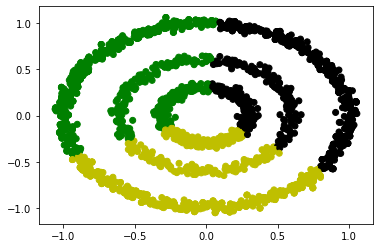

In [34]:
rocks = [[x_coordinates[i], y_coordinates[i]] for i in range(len(x_coordinates))]
rock_clusters = KMeans(3).fit_predict(rocks)

colors = [['g', 'y', 'k'][cluster] for cluster in  rock_clusters]
plt.scatter(x_coordinates, y_coordinates, color=colors) # color = colors(list):assign color for each point
plt.show()

The difference between clusters is driven not by centrality, but by density. Each ring is constructed from a dense collection of points, with empty areas of sparsely populated space serving as the boundaries between rings.<br/>
New Algo: A point is in a dense region only if it’s located within a distance X of Y other points.  
Every neighbor of a point in a dense region of space will also cluster in that space.  
EG: Searching for all the other rocks that are within epsilon units of rocks[0]. We’ll store the indices of these neighboring rocks in a neighbor_indices list.

In [35]:
epsilon=0.1 # X
min_points = 10 # Y
neighbor_indices = [i for i, rock in enumerate(rocks[1:]) if euclidean(rocks[0], rock) <= epsilon]

num_neighbors = len(neighbor_indices)
print(f"The rock at index 0 has {num_neighbors} neighbors.")

if num_neighbors >= min_points:
    print("It lies in a dense region.")
else:
    print("It does not lie in a dense region.")

The rock at index 0 has 40 neighbors.
It lies in a dense region.


In [36]:
dense_region_indices = [0] + neighbor_indices # combine rocks[0] and its neighbors into a single dense cluster.
dense_region_cluster = [rocks[i] for i in dense_region_indices]
dense_cluster_size = len(dense_region_cluster)
print(f"We found a dense cluster containing {dense_cluster_size} rocks")

We found a dense cluster containing 41 rocks


In [37]:
# Expanding a dense cluster: Points in the neighbor of any of the dense indices
dense_region_indices = set(dense_region_indices)
for index in neighbor_indices:
    point = rocks[index]
    neighbors_of_neighbors = [i for i, rock in enumerate(rocks) if euclidean(point, rock) <= epsilon]
    if len(neighbors_of_neighbors) >= min_points:
        dense_region_indices.update(neighbors_of_neighbors) #!!! set.update(list)
dense_region_cluster = [rocks[i] for i in dense_region_indices]
dense_cluster_size = len(dense_region_cluster)
print(f"We expanded our cluster to include {dense_cluster_size} rocks")

We expanded our cluster to include 781 rocks


We can expand our cluster even further by analyzing the density of newly encountered neighbors. Iteratively repeating our analysis will increase the breadth of our cluster boundary. Eventually, the boundary will spread to completely encompass one of our rock rings.  
Afterwards, with no new neighbors to absorb, we repeated the iterative analysis on a rocks element that has not been analyzed thus far. The repetition will lead to the clustering of another dense ring.

The procedure described is known as DBSCAN. The DBSCAN algorithm organizes data based on its spatial distribution.

#### DBSCAN: A Clustering Algorithm for Grouping Data Based on Spatial Density
DBSCAN: Density-based Spatial Clustering of Applications with Noise.
1. We select a random point coordinate from a data list.
2. We obtain all neighbors within an epsilon distance of that point.
3. If less than min_points neighbors are discovered, we repeat step 1. using a different random point. Otherwise, we group our point and its neighbors into a single cluster.
4. We iteratively repeat steps 2 and 3 across all newly discovered neighbors. All neighboring dense points will get merged into the cluster. Our will iterations terminate after the cluster stops expanding.
5. We repeat steps 1. through 4. on all data-points whose density hasn’t yet been analyzed.  

The difficulty in programming DBSCAN is that a speedy version requires some very nuanced optimizations. These optimizations improve neighbor traversal speed. Scikit-Learn makes DBSCAN available for use: import the DBSCAN class from sklearn.cluster. Initialize the class by assigning epsilon and min_points using the eps and min_samples parameters.

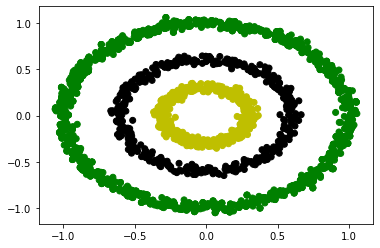

In [40]:
cluster_model = DBSCAN(eps=epsilon, min_samples=min_points) # 0.1/10
rock_clusters = cluster_model.fit_predict(rocks)
colors = [['g', 'y', 'k'][cluster] for cluster in rock_clusters]
plt.scatter(x_coordinates, y_coordinates, color=colors)
plt.show()

Compare with KMeans:  
1. For clustering data composed of curving and dense shapes. 
2. Doesn’t require an approximation of the cluster count prior to execution. 
3. DBSCAN can filter random outliers located in sparse regions of space. For example, DBSCAN will assign outliers a cluster id of -1. The negative value indicates that the outlier cannot be clustered with the rest of the dataset.
4. A fitted DBSCAN model cannot be re-applied to brand-new data. Instead, we’ll need to combine new and old data, and execute the clustering from scratch. The additional data-points could influence the density distribution of previously seen data, which forces DBSCAN to recompute all clusters.
5. The minimization property of KMeans only holds if the squared distances are Euclidean. Thus, if our coordinates are not Euclidean, then the mean is not very useful, and the K-means algorithm should not be applied. DBSCAN does not depend on the mean. 
6. K-means is guaranteed to converge to a solution. However, that solution might not be the optimal solution.

In [41]:
noisy_data = rocks + [[1000, -1000]]
clusters = DBSCAN(eps=epsilon,min_samples=min_points).fit_predict(noisy_data)
assert clusters[-1] == -1

### Clustering Based on Non-Euclidean Distance
manhattan_distance

In [43]:
def manhattan_distance(point_a, point_b):
    num_blocks = np.sum(np.absolute(point_a - point_b))
    return .17 * num_blocks  # 0.17 miles per block

x = np.array([34, 5])
y = np.array([57, 8])
distance = manhattan_distance(x, y)

print(f"Manhattan distance is {distance} miles")

Manhattan distance is 4.42 miles


Point at index 0 is in cluster 0
Point at index 1 is in cluster 0
Point at index 2 is in cluster 0
Point at index 3 is an outlier
Point at index 4 is an outlier


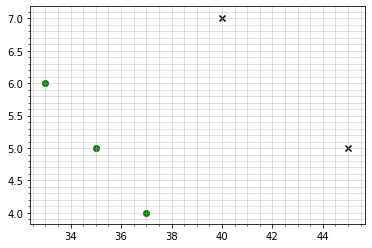

In [46]:
points = [[35, 5], [33, 6], [37, 4], [40, 7], [45, 5]]
clusters = DBSCAN(eps=1, min_samples=3,metric=manhattan_distance).fit_predict(points)

for i, cluster in enumerate(clusters):
    point = points[i]
    if cluster == -1:
        print(f"Point at index {i} is an outlier")
        plt.scatter(point[0], point[1], marker='x', color='k')
    else:
        print(f"Point at index {i} is in cluster {cluster}")
        plt.scatter(point[0], point[1], color='g')

plt.grid(True, which='both', alpha=0.5)
plt.minorticks_on() # smaller grids on 


plt.show()

#### Can use DBSCAN but not KMeans:

In [47]:
def ridiculous_measure(point_a, point_b):
    is_negative_a = np.array(point_a) < 0
    is_negative_b = np.array(point_b) < 0
    if is_negative_a.all() and is_negative_b.all():
        return 0
    elif is_negative_a.any() and is_negative_b.any():
        return 10
    else:
        return 2
# two points are zero units apart if all their elements are negative, 
# 2 units apart if all their elements are non-negative, and 10 units apart otherwise. 
# Given this ridiculous measure of distance, can we compute the mean of any 2 arbitrary points? We can’t, and K-means cannot be applied. 
# A weakness of the algorithm is that it depends on the existence of an average distance. 
# Unlike K-means, the DBSCAN algorithm does not require our distance function to be linearly divisible. 
# Thus, we can easily run DBSCAN clustering using our ridiculous distance metric.

points = [[-1, -1], [-10, -10], [-1000, -13435], [3,5], [5,-7]]

clusters = DBSCAN(eps=.1, min_samples=2,metric=ridiculous_measure).fit_predict(points)

for i, cluster in enumerate(clusters):
    point = points[i]
    if cluster == -1:
        print(f"{point} is an outlier")
    else:
        print(f"{point} falls in cluster {cluster}")

[-1, -1] falls in cluster 0
[-10, -10] falls in cluster 0
[-1000, -13435] falls in cluster 0
[3, 5] is an outlier
[5, -7] is an outlier


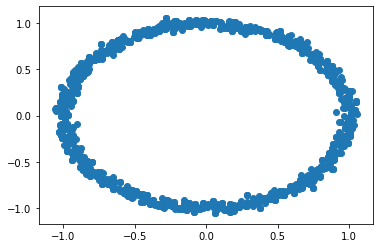

In [48]:
# Using pandas
import pandas as pd
x_coordinates, y_coordinates = np.array(rocks).T
df = pd.DataFrame({'X': x_coordinates, 'Y': y_coordinates,'Cluster': rock_clusters})

df_cluster = df[df.Cluster == 0]
plt.scatter(df_cluster.X, df_cluster.Y)
plt.show()

Skipping over cluster 0
Plotting cluster 1
Plotting cluster 2


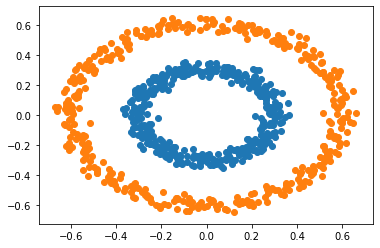

In [50]:
for cluster_id, df_cluster in df.groupby('Cluster'):
#!!! groupby will create 3 tables and return an [[iterable]] over the mappings between cluster ids and tables [as a tuple!].
    if cluster_id == 0:
        print(f"Skipping over cluster {cluster_id}")
        continue
    print(f"Plotting cluster {cluster_id}")
    plt.scatter(df_cluster.X, df_cluster.Y) # will autoly use different colors
plt.show()

### Process of DBSCAN and Limitations
dbscan_model = DBSCAN(eps=epsilon, min_samples=min_points, metric=metric_function) # default Euclidean distance
clusters = dbscan_model.fit_predict(data)

Drawbacks:  
The algorithm is intended to detect clusters with similar point-density distributions. However, real-world data varies in density. For instance, pizza shops in Manhattan are distributed more densely than the pizza shops in Orange County.  
DBSCAN requires meaningful values for the eps and min_samples parameters. Varying eps inputs will greatly impact the quality of clustering. Unfortunately, there is no one reliable procedure for estimating the appropriate eps.  
Generally speaking, if we are clustering random cities spread out across the Earth, then we can set the min_samples and eps parameters to equal 3 cities and 250 miles, respectively (heuristic). For a more regional location distribution, a lower eps value will be required.

## Plotting Maps Using Basemap
Basemap class is preset to display geographic data using a standard Equidistant cylindrical projection, in which the spherical globe is superimposed on an unrolled cylinder. This is the most popular 2D map representation.

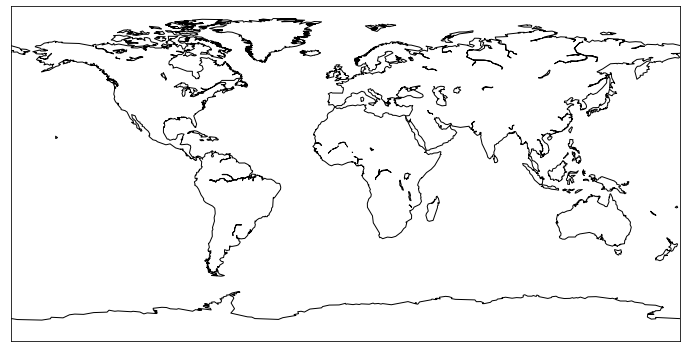

In [54]:
map_plotter = Basemap() # == map_plotter = Basemap(projection='cyl')
fig = plt.figure(figsize=(12, 8))
map_plotter.drawcoastlines() # coastlines of the continents
plt.show()

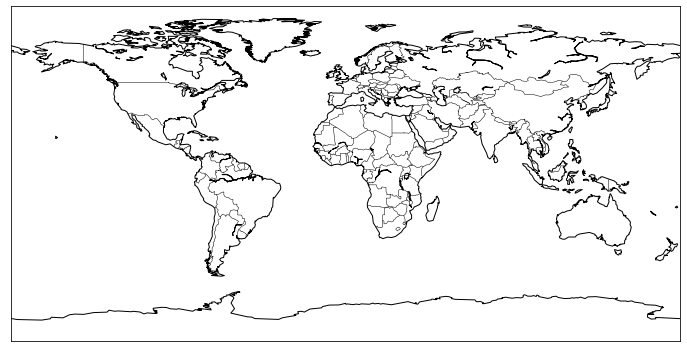

In [55]:
fig = plt.figure(figsize=(12, 8))
map_plotter.drawcoastlines()
map_plotter.drawcountries() # incorporate country boundaries 
plt.show()

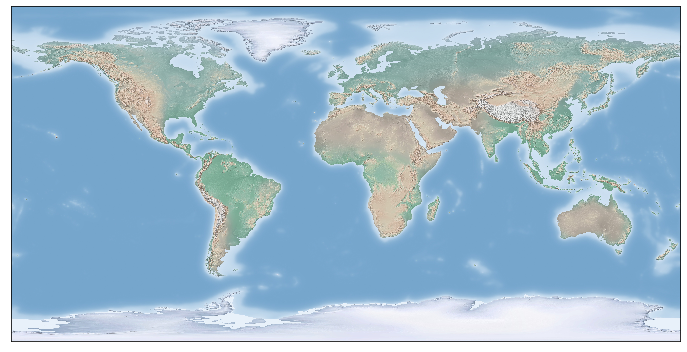

In [56]:
fig = plt.figure(figsize=(12, 8))
map_plotter.shadedrelief() # color the map using topographic information. Oceans blue, and forested green.

plt.show()

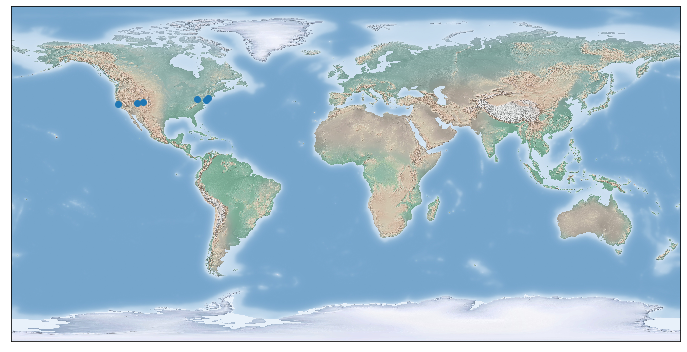

In [57]:
fig = plt.figure(figsize=(12, 8))
coordinates = [(39.9526, -75.1652), (37.7749, -122.4194),
               (40.4406, -79.9959), (38.6807, -108.9769),
               (37.8716, -112.2727), (40.7831, -73.9712)]

latitudes, longitudes = np.array(coordinates).T
map_plotter.scatter(longitudes, latitudes, latlon=True) # latlon=True: points are treated as spherical coordinates.(in degrees)
map_plotter.shadedrelief()
plt.show()

The plotted points all appear within the boundaries of North America. We thusly can simplify the map by zooming in on North America.   
Orthographic projection: plots the Earth from the perspective of a viewer in the outer reaches of the galaxy. The distant observer cannot see the entire Earth, but only a part of it. We’ll center the perspective of the viewer on North America (latitude and longitude of (40, -95)).

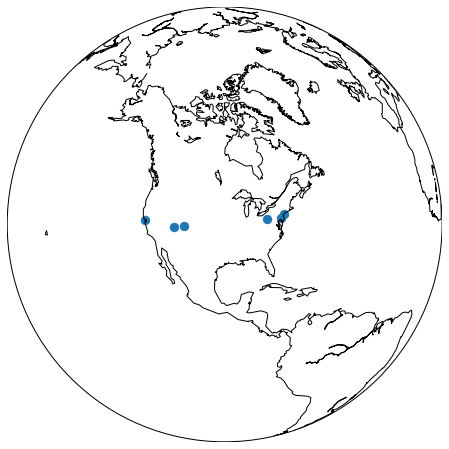

In [58]:
fig = plt.figure(figsize=(12, 8))
map_ortho = Basemap(projection='ortho', lat_0=40, lon_0=-95) # center the perspective of the viewer on North America
map_ortho.scatter(longitudes, latitudes, latlon=True, s=70)
map_ortho.drawcoastlines()
plt.show()

Zoom in further, onto the United States.  
Orthographic projection will prove insufficient for this purpose. Instead, we will on rely on the Lambart conformal conic projection, (more commonly called the LCC). Create a 2D map of the United States.  
We need all these parameters because the LCC is a complex, multi-step procedure. Initially, the projection places a cone on-top of the spherical Earth. The cone’s circular base covers the region we intend to map. Afterwards, coordinates in the region are projected onto the surface of the cone. Finally, the cone is unrolled to create a 2D map. This process requires many fine-tuned parameters to execute appropriately.

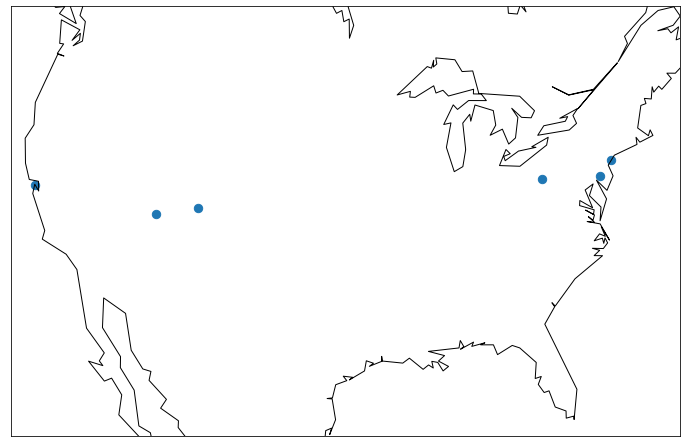

In [59]:
fig = plt.figure(figsize=(12, 8))
map_lcc = Basemap(projection='lcc', lon_0=-95, llcrnrlon=-119,
                  llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49, lat_1=33,
                  lat_2=45) 
map_lcc.scatter(longitudes, latitudes, latlon=True, s=70)
map_lcc.drawcoastlines()
plt.show()

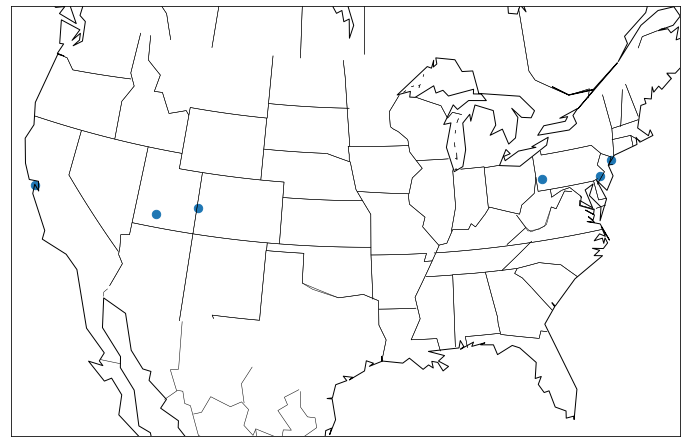

In [60]:
fig = plt.figure(figsize=(12, 8))
map_lcc.scatter(longitudes, latitudes, latlon=True, s=70)
map_lcc.drawcoastlines()
map_lcc.drawstates() # Draw States
plt.show()